## Deep Q Learning (DQN) agent on the CartPole-v0 task from the OpenAI Gym

### OpenAI Gym 中的基本概念

如果算法想做得更好, 而不是在每一步都采取随机的行动, 只有真正了解算法的行为对环境的影响才可能会更好.

环境(environment)的 `step` 函数返回的正是我们所需要的. 实际上, `step` 返回四个值. 这些都是:

- observation: 特定于环境的对象，表示您对环境的观察. 例如，来自摄像机的像素数据, 机器人的关节角度和关节速度, 或棋盘游戏中的棋盘状态.

- reward: 前一个动作所获得的奖励量. 在不同的环境中, 这个范围是不同的, 但是目标总是要增加总回报。

- done: 重新设置(reset)环境的标志.
大多数(但不是所有)任务被划分为定义良好的场景(episodes), done为真表示场景已经终止.(例如, 也许杆子倒得太远了.)

- info: 对调试有用的诊断信息. 它有时对学习很有用(例如，它可能包含环境最后一次状态更改后的原始概率). 

<div align="center">
    <img style="border-radius: 0.3125em; box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"
    height="150"
    src="https://github.com/ximingxing/Images/raw/master/dlic/agent-environment%20loop.svg">
    <br>
    <div style="border-bottom: 1px solid #d9d9d9;display:inline-block;color: #999;padding: 2px;
    font-style: oblique; font-family: 'Times New Roman'">
    Figure: Agent-Environment Loop</div>
</div>

###  CartPole-v0 task 任务目标

- Agent(决策者 -- model)必须在两种动作(action)中做出选择（向左或向右移动手推车）这样连接在手推车上的杆子才能保持直立。

### Import Packages

- 首先我们需要 gym 环境:
    `pip install gym`

- 和其他关于 pytorch 的库:
    - neural networks (torch.nn)
    - optimization (torch.optim)
    - automatic differentiation (torch.autograd)
    - utilities for vision tasks (torchvision - a separate package).

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

### Replay Memory

- `Transition` 表示环境中单个转换的命名元组。
它实际上将 `(state, action)` 对映射到它们的 `(next_state, reward)` 结果 (状态是屏幕差异图像).

- `ReplayMemory` 一种大小有界的循环缓冲区，用于保存最近观察到的 `Transitions`。
它还实现了一个 `.sample()` 方法，用于选择用于训练的随机一批 `Transitions`.

#### 作用

1. 储存过去遇到的 `Transition`
2. 忘记太过久远的 `Transition`
3. 训练时, 从 `ReplayMemory` 随机抽样

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN algorithm

我们的目标将是训练一种试图最大化累积回报(reward)的政策(policy) :

$$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$$

where $R_{t_0}$ 是返回值, 递减因子 $\gamma$ 应该是一个介于0和1之间的常量，以确保和收敛.

Q-learning 背后的主要思想是, 如果我们有一个函数 $Q^*: State \times Action \rightarrow \mathbb{R}$ ,
能告诉我们得到的是什么, 如果我们在一个给定的状态(state)下, 要执行一个行为(action), 
然后我们可以很容易地构造一个策略(policy), 以最大化回报(reward) :

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

然而, 我们无法知晓真实世界下的所有情况, 所以我们不能直接求的$Q^*$,
但是, 由于神经网络可以看作通用函数逼近器, 可以利用神经网络训练并近似$Q^*$ :

训练更新规则是 , 对于某些策略(policy), 每个 $Q$ 函数都遵守 Bellman 方程 :

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

这里 $r$ 表示当前状态下的奖励, 
$Q^{\pi}(s', \pi(s'))$ 表示神经网络预测后续若干个状态中执行action对应奖励,
$\gamma$ 代表第二项递减因子, 由于神经网络预测距离当前state越远的reward可能是越不准确的, 
等式两边的差称为 时序差分误差(temporal difference error), $\delta$ :

$$\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))$$

为了最小化这个误差, 我们使用 `Huber loss`. 

> 当误差很小的时候, `Huber loss`就像均方误差(MSE), 但当误差很大的时候, 就像绝对平均误差(MAE), 当 $Q$ 的近似有很大的噪声时，这使得它对离群值更加鲁棒.

我们通过从Replay Memory中采样的一批Transition来计算:
 
$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$
\begin{split}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}\end{split}
$$

<div align="center">
    <img style="border-radius: 0.3125em; box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"
    height="200"
    src="https://github.com/ximingxing/Images/raw/master/dlic/reinforcement_learning_diagram.jpg">
    <br>
    <div style="border-bottom: 1px solid #d9d9d9;display:inline-block;color: #999;padding: 2px;
    font-style: oblique; font-family: 'Times New Roman'">
    Figure: Reinforcement Learning Diagram</div>
</div>

行为(action)可以随机选择, 也可以基于策略(policy), 从`Gym`环境(environment)中采样下一步的样本。
我们将结果(result)记录在回放内存(replay memory)中，并在每次迭代中运行优化步骤。
优化从回放内存(replay memory)中随机挑选一些批次(batch)来进行新策略(policy)的训练。
Target net也用于优化计算期望Q的值;它偶尔会更新以保持最新。

In [3]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            """conv2d layer output size"""
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Input extraction

下面的代码用于从环境(environment)中提取和处理呈现图像 (基于`torchvision`库).

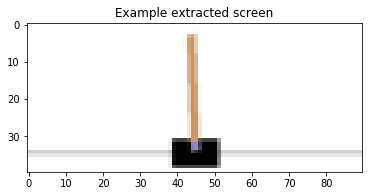

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

### Training

#### Hyperparameters and utilities

- `select_action` 将根据贪心策略选择相应的行为(action). 简单地说, 我们有时会用我们的模型来选择行为, 有时我们会统一地选取一个.
选择随机动作的概率将从 `EPS_START` 开始，并以指数方式衰减到 `EPS_END`. `EPS_DECAY` 控制衰变的速率.

- `plot_durations` 帮助绘制场景(episodes)的时长，以及最近100个场景(episodes)的平均时长.

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### Training loop

在这里, `optimize_model` 函数，它执行优化的单个步骤.
它首先对一批张量进行采样(state, action, reward)，将所有的张量串联成一个张量, 
然后分别计算 $Q(s_t, a_t)$ 和 $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, 将其合并为训练损失(loss).
当状态变为为终止状态(terminal state)时, 对应 $V(s) = 0$,
我们还使用一个目标网络(target network)来计算 $V(s_{t+1})$ 以增加稳定性.

> 目标网络(target network)的权值在大部分时间内保持不变，但时不时地会更新策略网络(policy network)的权值, 
> 这里用一个情节(episodes)表示.

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

下面是主要的训练循环.
在开始我们重置环境和初始化状态(state)张量.
然后，我们对一个动作(action)采样, 执行它, 观察下一个屏幕(screen)和奖励(reward), 并优化我们的模型一次.
当情节(episode)结束(我们的模型失败), 我们重新启动循环.

In [7]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>